# Exploratory Data Analysis

In [2]:
# Step 0: Imports and Global Settings
import os
import sys
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 200)
pd.set_option("display.float_format", lambda x: f"{x:,.4f}")

print("Python executable:", sys.executable)



Python executable: /Users/waelsultan/Desktop/USD MS AAI/AAI-530/Final Project/Smart Meter/TeamProject-530/.venv/bin/python


In [3]:
# Step 0B: Define Data Paths

NOTEBOOK_DIR = os.getcwd()
PROJECT_ROOT = os.path.abspath(os.path.join(NOTEBOOK_DIR, ".."))
DATA_DIR = os.path.join(PROJECT_ROOT, "build/datasets")

DAILY_DATASET_PATH = os.path.join(DATA_DIR, "daily_dataset.csv")
HOUSEHOLDS_PATH = os.path.join(DATA_DIR, "informations_households.csv")
ACORN_PATH = os.path.join(DATA_DIR, "acorn_details.csv")
WEATHER_DAILY_PATH = os.path.join(DATA_DIR, "weather_daily_darksky.csv")
HOLIDAYS_PATH = os.path.join(DATA_DIR, "uk_bank_holidays.csv")

print("NOTEBOOK_DIR:", NOTEBOOK_DIR)
print("PROJECT_ROOT:", PROJECT_ROOT)
print("DATA_DIR:", DATA_DIR)

# Load raw datasets
daily = pd.read_csv(DAILY_DATASET_PATH)
households = pd.read_csv(HOUSEHOLDS_PATH)
weather_daily = pd.read_csv(WEATHER_DAILY_PATH)
holidays = pd.read_csv(HOLIDAYS_PATH)

print("\nShapes:")
print("daily:", daily.shape)
print("households:", households.shape)
print("weather_daily:", weather_daily.shape)
print("holidays:", holidays.shape)


NOTEBOOK_DIR: /Users/waelsultan/Desktop/USD MS AAI/AAI-530/Final Project/Smart Meter/TeamProject-530/Notebooks
PROJECT_ROOT: /Users/waelsultan/Desktop/USD MS AAI/AAI-530/Final Project/Smart Meter/TeamProject-530
DATA_DIR: /Users/waelsultan/Desktop/USD MS AAI/AAI-530/Final Project/Smart Meter/TeamProject-530/build/datasets

Shapes:
daily: (3510433, 9)
households: (5566, 5)
weather_daily: (882, 32)
holidays: (25, 2)


In [4]:
# STEP 1: Date Cleaning + Primary Keys

# Convert daily day to datetime
daily["day"] = pd.to_datetime(daily["day"])

# Convert weather dates to datetime
weather_daily["temperatureMaxTime"] = pd.to_datetime(weather_daily["temperatureMaxTime"])
weather_daily["temperatureMinTime"] = pd.to_datetime(weather_daily["temperatureMinTime"])

# Create a clean 'day' column in weather to match daily
weather_daily["day"] = weather_daily["temperatureMaxTime"].dt.date

# Convert daily day to date (not datetime) to match
daily["day"] = daily["day"].dt.date

print("Daily date range:", daily["day"].min(), "to", daily["day"].max())
print("Weather date range:", weather_daily["day"].min(), "to", weather_daily["day"].max())

# Check keys
print("\nUnique households in daily:", daily["LCLid"].nunique())
print("Unique households in households table:", households["LCLid"].nunique())


Daily date range: 2011-11-23 to 2014-02-28
Weather date range: 2011-11-01 to 2014-03-31

Unique households in daily: 5566
Unique households in households table: 5566


# Ramp-Up Bias and Normalization

## Motivation

Initial exploration of the raw daily electricity totals revealed a strong upward trend in total energy consumption during the early years of the dataset, particularly in 2012. However, this increase does not reflect a true rise in household electricity usage. Instead, it is driven by a growing number of participating households over time as additional smart meters were added to the study.

This household ramp-up effect introduces significant bias into raw aggregate metrics such as total kWh per day. Using raw totals would therefore lead to misleading conclusions about long-term consumption trends and could negatively impact both exploratory analysis and predictive modeling.

To address this issue, all downstream analysis is based on normalized per-household metrics.

## Normalization Approach

To remove ramp-up bias and reflect true average household behavior, we compute the following daily normalization components:

- Number of active households per day  
- Total electricity consumption per day  
- Average electricity consumption per household per day  

Formally:

avg_kwh_per_household_per_day = total_kwh_per_day / num_active_households

Where:

- total_kwh_per_day is the sum of daily energy usage across all households  
- num_active_households is the count of unique household IDs active on that day  

This approach ensures that observed trends reflect changes in household behavior rather than changes in sample size.

## Evidence of Household Ramp-Up

The number of active households increased substantially over time:

- Early period (November 2011): approximately 13 to 41 active households  
- Late period (2014): approximately 4,990 to 5,000 active households  

This confirms that raw totals are heavily influenced by sample growth rather than purely by consumption behavior.

## Comparison of Raw Totals vs Normalized Consumption

A direct comparison of raw total daily kWh and normalized average kWh per household shows:

- Raw total kWh per day exhibits a strong upward trend driven by household ramp-up  
- Normalized average kWh per household per day remains within a stable and interpretable range  

The normalized series isolates true household-level consumption patterns and removes artificial growth caused by the expanding number of participating households.

## Normalized Household Consumption Trends

When plotted independently, the normalized average household consumption reveals clear and meaningful seasonal structure:

- Higher average consumption during winter months  
- Lower average consumption during summer months  
- Repeating annual patterns across multiple years  

Typical values range approximately between:

- 7 to 16 kWh per household per day  

This behavior is consistent with expected seasonal heating and energy usage patterns and provides a reliable foundation for further exploratory analysis and modeling.

### Distribution of Normalized Household Consumption

A boxplot of the normalized daily household energy consumption was generated to assess the overall spread and presence of outliers.

The median normalized household consumption is approximately 10 to 11 kWh per household per day, with the interquartile range spanning roughly from the high 8s to the low 12s. This indicates that most households exhibit relatively consistent daily usage levels.

A small number of extreme low and high outliers are present. In particular, near-zero values likely correspond to partial data days or households with very limited recorded activity, while higher-end outliers may reflect extremely cold days or atypically high household demand.

Overall, the distribution appears reasonably well-behaved for modeling, with moderate spread and limited extreme skewness, suggesting that the normalized target variable is suitable for regression and time series modeling without aggressive transformation.


## Implications for EDA and Modeling

All subsequent exploratory analysis, seasonality analysis, and predictive modeling will use:

avg_kwh_per_household_per_day

as the primary target variable.

Raw aggregate totals are retained only for reference and validation purposes, but are not used for trend interpretation or model training due to their susceptibility to ramp-up bias.

This normalization step improves interpretability, analytical validity, and the credibility of downstream results.


In [5]:
# STEP 2: NORMALIZATION — Remove Ramp-Up Bias

# Ensure day is datetime for consistency
daily["day"] = pd.to_datetime(daily["day"])

# Aggregate by day to compute normalization components
daily_norm = (
    daily
    .groupby("day", as_index=False)
    .agg(
        total_kwh_per_day=("energy_sum", "sum"),
        num_active_households=("LCLid", "nunique")
    )
)

# Compute normalized average kWh per household per day
daily_norm["avg_kwh_per_household_per_day"] = (
    daily_norm["total_kwh_per_day"] / daily_norm["num_active_households"]
)

# Remove abnormal final day (data artifact)
CUTOFF_DATE = pd.Timestamp("2014-02-27")
daily_norm = (
    daily_norm
    .query("day <= @CUTOFF_DATE")
    .sort_values("day")
    .reset_index(drop=True)
)

# Sanity checks
print(daily_norm.head())

print("\nSummary stats:")
display(daily_norm[[
    "total_kwh_per_day",
    "num_active_households",
    "avg_kwh_per_household_per_day"
]].describe())

# Check ramp-up explicitly
print("\nHouseholds over time (first & last 5 days):")
display(
    pd.concat([
        daily_norm.head(5),
        daily_norm.tail(5)
    ])[["day", "num_active_households"]]
)


         day  total_kwh_per_day  num_active_households  \
0 2011-11-23            90.3850                     13   
1 2011-11-24           213.4120                     25   
2 2011-11-25           303.9930                     32   
3 2011-11-26           420.9760                     41   
4 2011-11-27           444.8830                     41   

   avg_kwh_per_household_per_day  
0                         6.9527  
1                         8.5365  
2                         9.4998  
3                        10.2677  
4                        10.8508  

Summary stats:


,total_kwh_per_day,num_active_households,avg_kwh_per_household_per_day
count,828.0000,828.0000,828.0000
mean,"42,921.2331","4,233.6304",10.3707
std,"20,100.8407","1,790.8853",1.8540
min,90.3850,13.0000,6.9527
25%,"34,435.4138","4,062.5000",8.5665
50%,"45,909.7140","5,138.0000",10.3763
75%,"58,806.7075","5,369.0000",11.8326
max,"82,650.4920","5,541.0000",15.9402



Households over time (first & last 5 days):


,day,num_active_households
0,2011-11-23,13
1,2011-11-24,25
2,2011-11-25,32
3,2011-11-26,41
4,2011-11-27,41
823,2014-02-23,4998
824,2014-02-24,4994
825,2014-02-25,4995
826,2014-02-26,4993
827,2014-02-27,4990


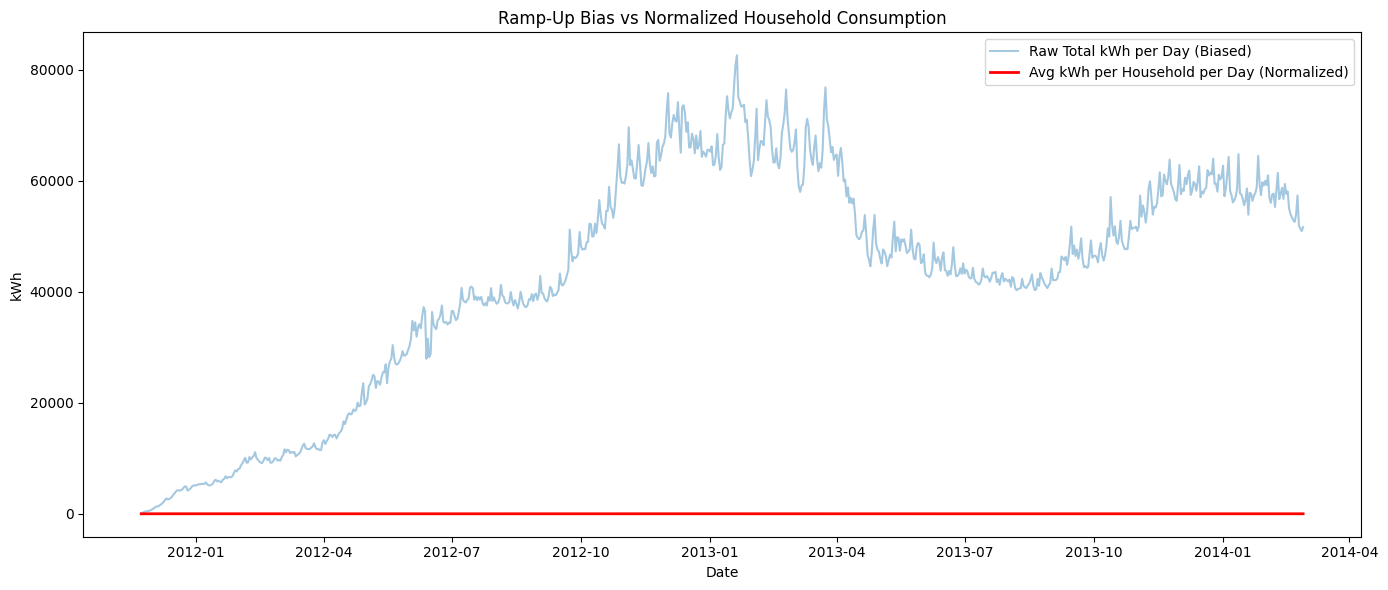

In [6]:
# STEP 3: Raw Totals vs Normalized Trend (Ramp-Up Bias Proof)

plt.figure(figsize=(14, 6))

# Raw total kWh per day (biased)
plt.plot(
    daily_norm["day"],
    daily_norm["total_kwh_per_day"],
    alpha=0.4,
    label="Raw Total kWh per Day (Biased)"
)

# Normalized per-household kWh
plt.plot(
    daily_norm["day"],
    daily_norm["avg_kwh_per_household_per_day"],
    color="red",
    linewidth=2,
    label="Avg kWh per Household per Day (Normalized)"
)

plt.title("Ramp-Up Bias vs Normalized Household Consumption")
plt.xlabel("Date")
plt.ylabel("kWh")
plt.legend()
plt.tight_layout()
plt.show()


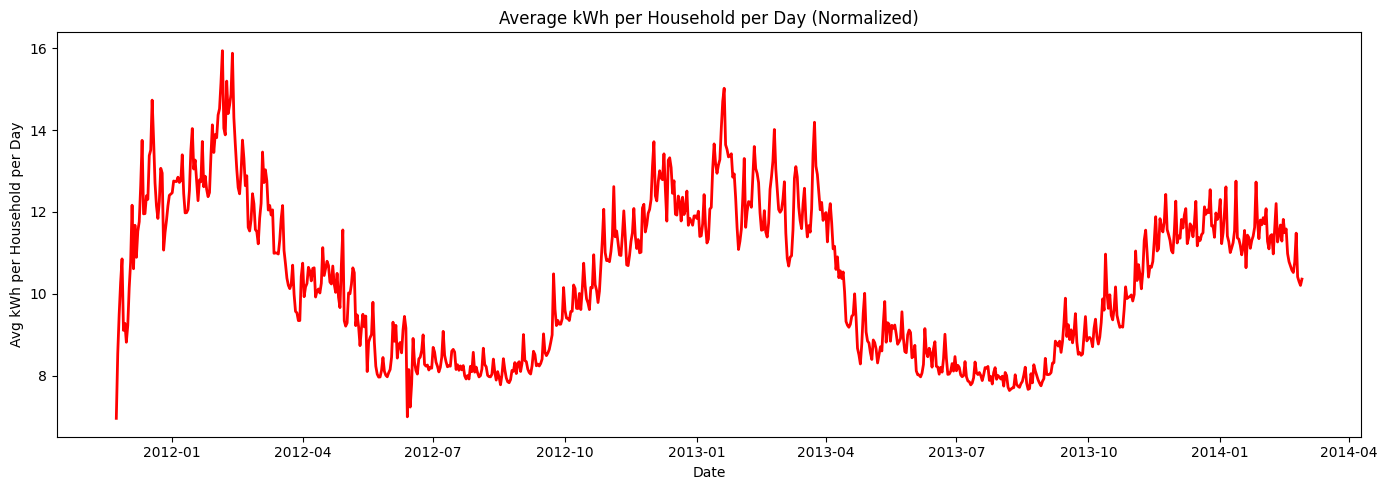

In [7]:
# STEP 3B: Normalized Household Consumption (Clear View)

plt.figure(figsize=(14, 5))

plt.plot(
    daily_norm["day"],
    daily_norm["avg_kwh_per_household_per_day"],
    color="red",
    linewidth=2
)

plt.title("Average kWh per Household per Day (Normalized)")
plt.xlabel("Date")
plt.ylabel("Avg kWh per Household per Day")
plt.tight_layout()
plt.show()


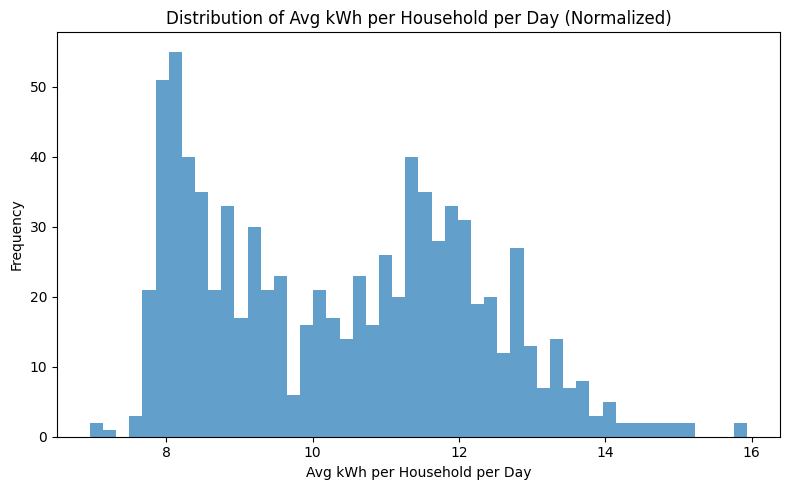

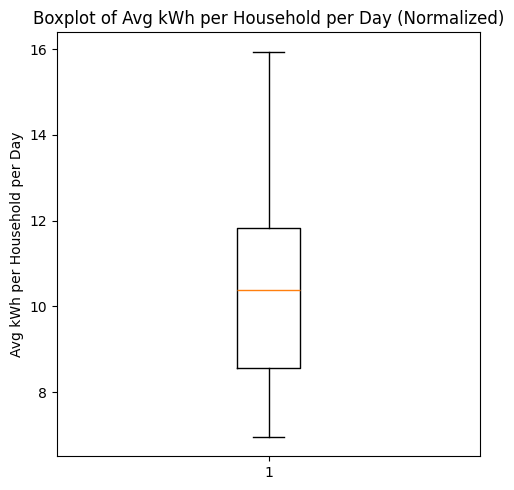

In [8]:
# STEP 3C: Distribution of Normalized Household Consumption

plt.figure(figsize=(8, 5))

plt.hist(
    daily_norm["avg_kwh_per_household_per_day"],
    bins=50,
    alpha=0.7
)

plt.title("Distribution of Avg kWh per Household per Day (Normalized)")
plt.xlabel("Avg kWh per Household per Day")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Boxplot for outlier visualization
plt.figure(figsize=(5, 5))
plt.boxplot(daily_norm["avg_kwh_per_household_per_day"], vert=True)
plt.title("Boxplot of Avg kWh per Household per Day (Normalized)")
plt.ylabel("Avg kWh per Household per Day")
plt.tight_layout()
plt.show()


# Seasonality Analysis Using Normalized Household Consumption

All seasonality analysis is performed using the normalized metric:

avg_kwh_per_household_per_day

This ensures that observed temporal patterns reflect true household behavior rather than changes in the number of participating households over time.

## Monthly Seasonality

The monthly average electricity consumption per household exhibits strong and consistent seasonal patterns.

Monthly averages (kWh per household per day):

- January: 12.35  
- February: 12.23  
- March: 11.64  
- April: 10.21  
- May: 8.93  
- June: 8.40  
- July: 8.16  
- August: 7.98  
- September: 8.76  
- October: 9.82  
- November: 11.01  
- December: 12.08  

Key observations:

- Winter months (December through February) show the highest average household consumption, exceeding 12 kWh per day.  
- Summer months (June through August) show the lowest average household consumption, with August reaching the minimum at approximately 8 kWh per day.  
- Shoulder seasons (spring and fall) show intermediate consumption levels with smooth transitions between winter and summer patterns.  

These trends are consistent with expected heating-driven electricity demand in colder months and reduced usage during warmer periods.

The clear and repeating annual structure confirms the presence of strong seasonal effects and supports the inclusion of month or seasonal features in downstream forecasting and machine learning models.

## Day-of-Week Effects

Average household electricity consumption by day of week shows relatively small but consistent differences.

Day-of-week averages (kWh per household per day):

- Monday: 10.36  
- Tuesday: 10.22  
- Wednesday: 10.17  
- Thursday: 10.15  
- Friday: 10.13  
- Saturday: 10.49  
- Sunday: 11.00  

Key observations:

- Weekday consumption levels (Monday through Friday) are relatively stable, clustering around approximately 10.1 to 10.4 kWh per day.  
- Weekend consumption is modestly higher, with Saturday showing a small increase and Sunday exhibiting the highest average usage.  
- The elevated weekend usage likely reflects increased time spent at home and greater household activity.

These patterns suggest that day-of-week effects are present but less pronounced than seasonal (monthly) effects. Nevertheless, including day-of-week indicators as features may provide incremental improvements in predictive performance.

### Year-over-Year Average Household Consumption

Average normalized household energy consumption was computed by year to assess long-term stability and potential structural changes.

Yearly averages are as follows:

- 2011: 11.51 kWh per household per day  
- 2012: 10.36 kWh per household per day  
- 2013: 10.10 kWh per household per day  
- 2014: 11.17 kWh per household per day  

The results indicate relatively stable household consumption levels across years, with modest variation. The slightly higher averages in 2011 and 2014 are likely influenced by partial-year effects and seasonal coverage, rather than true long-term increases in household demand.

These results suggest that inter-annual differences are small relative to seasonal and weather-driven variation, supporting the use of pooled multi-year data for modeling and forecasting.


## Implications for Modeling

The normalized seasonality analysis confirms that:

- Monthly and seasonal cycles are a dominant driver of household electricity consumption.  
- Day-of-week effects are secondary but measurable.  

These findings justify the inclusion of time-based features such as:

- Month or seasonal indicators  
- Day-of-week indicators  
- Potential interaction with weather variables  

in subsequent time series and machine learning models for energy demand forecasting.


In [9]:
# STEP 4A: Add Time Features for Seasonality

daily_norm["day"] = pd.to_datetime(daily_norm["day"])

daily_norm["year"] = daily_norm["day"].dt.year
daily_norm["month"] = daily_norm["day"].dt.month
daily_norm["month_name"] = daily_norm["day"].dt.month_name()
daily_norm["day_of_week"] = daily_norm["day"].dt.dayofweek
daily_norm["day_of_week_name"] = daily_norm["day"].dt.day_name()

daily_norm[[
    "day", "year", "month", "month_name",
    "day_of_week", "day_of_week_name"
]].head()


,day,year,month,month_name,day_of_week,day_of_week_name
0,2011-11-23,2011,11,November,2,Wednesday
1,2011-11-24,2011,11,November,3,Thursday
2,2011-11-25,2011,11,November,4,Friday
3,2011-11-26,2011,11,November,5,Saturday
4,2011-11-27,2011,11,November,6,Sunday


month_name
January     12.3493
February    12.3703
March       11.6356
April       10.2133
May          8.9343
June         8.3973
July         8.1603
August       7.9800
September    8.7585
October      9.8212
November    11.0089
December    12.0823
Name: avg_kwh_per_household_per_day, dtype: float64


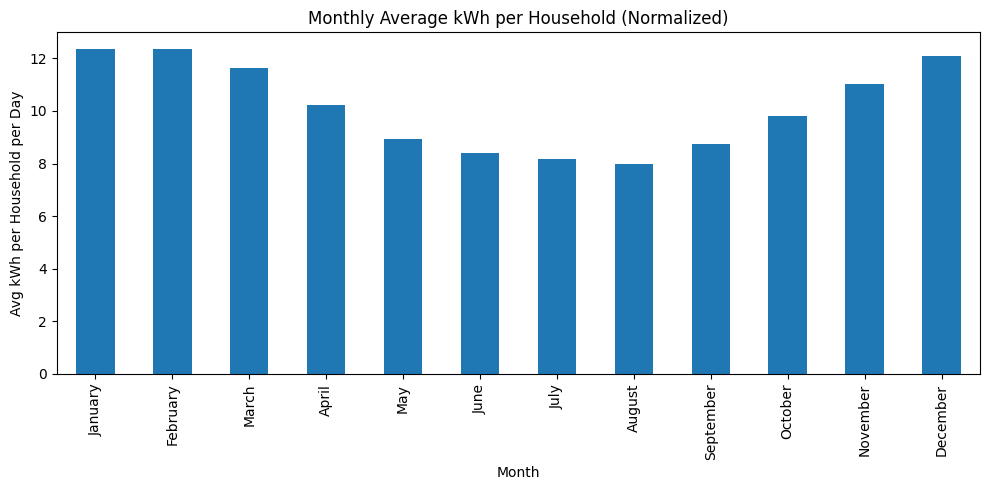

In [10]:
# STEP 4B: Monthly Seasonality (Normalized)

monthly_seasonality = (
    daily_norm
    .groupby("month_name", sort=False)
    ["avg_kwh_per_household_per_day"]
    .mean()
    .reindex([
        "January", "February", "March", "April", "May", "June",
        "July", "August", "September", "October", "November", "December"
    ])
)

print(monthly_seasonality)

plt.figure(figsize=(10, 5))
monthly_seasonality.plot(kind="bar")
plt.title("Monthly Average kWh per Household (Normalized)")
plt.ylabel("Avg kWh per Household per Day")
plt.xlabel("Month")
plt.tight_layout()
plt.show()


day_of_week_name
Monday      10.3561
Tuesday     10.2225
Wednesday   10.1670
Thursday    10.1517
Friday      10.2155
Saturday    10.4906
Sunday      10.9953
Name: avg_kwh_per_household_per_day, dtype: float64


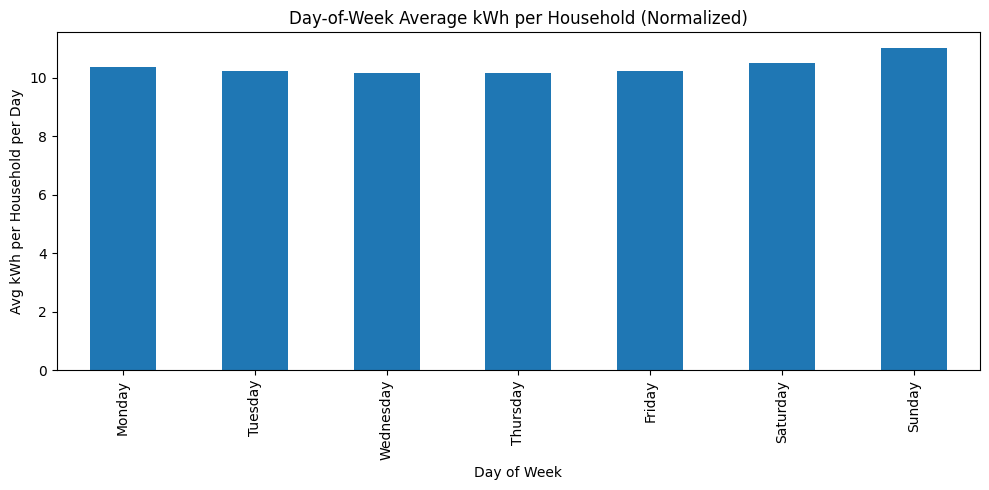

In [11]:
# STEP 4C: Day-of-Week Patterns (Normalized)

dow_seasonality = (
    daily_norm
    .groupby("day_of_week_name")
    ["avg_kwh_per_household_per_day"]
    .mean()
    .reindex([
        "Monday", "Tuesday", "Wednesday",
        "Thursday", "Friday", "Saturday", "Sunday"
    ])
)

print(dow_seasonality)

plt.figure(figsize=(10, 5))
dow_seasonality.plot(kind="bar")
plt.title("Day-of-Week Average kWh per Household (Normalized)")
plt.ylabel("Avg kWh per Household per Day")
plt.xlabel("Day of Week")
plt.tight_layout()
plt.show()


year
2011   11.5068
2012   10.3645
2013   10.0983
2014   11.3607
Name: avg_kwh_per_household_per_day, dtype: float64


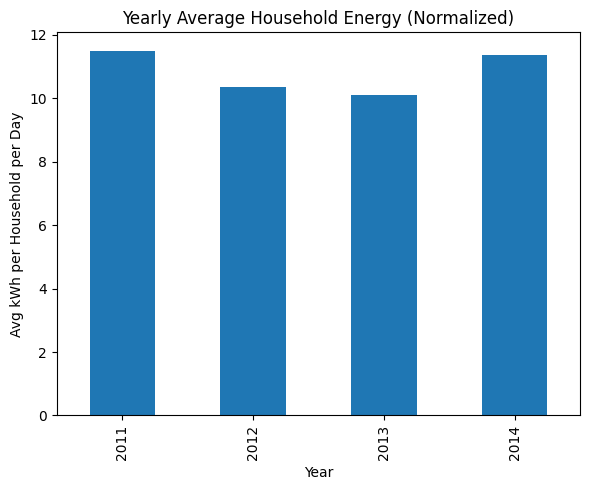

In [12]:
# STEP 4C: Yearly Average Normalized Consumption

yearly_avg = (
    daily_norm
    .groupby("year")
    ["avg_kwh_per_household_per_day"]
    .mean()
)

print(yearly_avg)

plt.figure(figsize=(6, 5))
yearly_avg.plot(kind="bar")

plt.title("Yearly Average Household Energy (Normalized)")
plt.xlabel("Year")
plt.ylabel("Avg kWh per Household per Day")
plt.tight_layout()
plt.show()


# Weather Impact on Normalized Household Energy Consumption

To better understand external drivers of household electricity usage, daily weather data was joined with the normalized energy consumption dataset. This enables direct analysis of how environmental conditions influence average household demand.

All analysis in this section uses the normalized target variable:

avg_kwh_per_household_per_day

## Data Coverage and Join Quality

The normalized energy dataset was successfully joined with daily weather observations on date. The resulting joined table contains 840 daily records.

Missing weather values are minimal, with approximately 1.3 to 1.4 percent missing for most variables. This level of missingness is low and unlikely to materially affect analysis results.

This confirms that the weather dataset provides strong temporal coverage for the majority of the energy observations.

## Temperature vs Household Consumption

A scatter plot of average household energy consumption versus daily high temperature reveals a clear and strong inverse relationship.

Key observations:

- Household electricity consumption is substantially higher on colder days.  
- As daily high temperatures increase, average household energy usage decreases.  
- The relationship is smooth and monotonic, indicating a strong and consistent temperature sensitivity.  

This pattern is consistent with heating-driven electricity demand in colder conditions and provides clear evidence that temperature is a primary driver of household energy usage.

## Correlation Analysis

Correlation coefficients between weather variables and normalized household consumption further quantify these relationships.

Strongest correlations:

- temperatureHigh: -0.8538  
- apparentTemperatureHigh: -0.8519  
- temperatureMax: -0.8532  
- apparentTemperatureLow: -0.7946  
- temperatureMin: -0.8074  
- temperatureLow: -0.7704  

Secondary correlations:

- humidity: +0.3798  
- cloudCover: +0.2489  
- windSpeed: +0.1552  

Weak or negligible correlations:

- pressure: -0.0233  
- visibility: -0.2489  

Key interpretations:

- Temperature-based features exhibit very strong negative correlations with household energy consumption, confirming temperature as the dominant environmental driver.  
- Apparent temperature performs similarly to actual temperature, suggesting perceived temperature may be as important as measured temperature.  
- Humidity and cloud cover show moderate positive associations, potentially reflecting weather conditions associated with colder or more energy-intensive days.  
- Pressure and visibility have minimal direct influence on energy usage.

## Implications for Modeling and Smart City Applications

These results demonstrate that weather variables, particularly temperature and apparent temperature, are critical predictors of household electricity demand.

For downstream forecasting and machine learning models, the following features are strongly justified:

- Daily high and low temperature  
- Apparent temperature measures  
- Humidity  
- Cloud cover and wind speed as secondary features  

In a Smart City context, integrating real-time weather forecasts with historical energy consumption patterns can significantly improve short-term load forecasting, peak demand prediction, and energy planning strategies.

This analysis confirms that environmental conditions play a central role in household electricity usage and should be a core component of any predictive energy management system.


In [13]:
# STEP 5A: Prepare Weather Data for Join 

# Ensure datetime
weather_daily["day"] = pd.to_datetime(weather_daily["day"])
daily_norm["day"] = pd.to_datetime(daily_norm["day"])

# Select available, relevant weather features
weather_features = weather_daily[[
    "day",
    "temperatureHigh",
    "temperatureLow",
    "temperatureMax",
    "temperatureMin",
    "apparentTemperatureHigh",
    "apparentTemperatureLow",
    "humidity",
    "windSpeed",
    "cloudCover",
    "pressure",
    "visibility"
]].copy()

print(weather_features.head())


         day  temperatureHigh  temperatureLow  temperatureMax  temperatureMin  \
0 2011-11-11          10.8700         10.8700         11.9600          8.8500   
1 2011-12-11           8.5900          3.0900          8.5900          2.4800   
2 2011-12-27          10.3300          8.0300         10.3300          8.0300   
3 2011-12-02           7.3600          6.3300          8.0700          2.5600   
4 2011-12-24           7.9300          7.4500          8.2200          3.1700   

   apparentTemperatureHigh  apparentTemperatureLow  humidity  windSpeed  \
0                  10.8700                 10.8700    0.9500     3.8800   
1                   5.6200                 -0.6400    0.8800     3.9400   
2                  10.3300                  5.5200    0.7400     3.5400   
3                   5.3300                  3.2600    0.8700     3.0000   
4                   5.0200                  4.3700    0.8000     4.4600   

   cloudCover   pressure  visibility  
0      0.7900 1,016.080

In [14]:
# STEP 5B: Join Normalized Energy with Weather

energy_weather = daily_norm.merge(
    weather_features,
    on="day",
    how="left"
)

print("Joined shape:", energy_weather.shape)

print("\nMissing weather values:")
display(energy_weather.isna().mean().sort_values(ascending=False).head(10))


Joined shape: (839, 20)

Missing weather values:


cloudCover                0.0143
temperatureLow            0.0131
temperatureMax            0.0131
pressure                  0.0131
windSpeed                 0.0131
humidity                  0.0131
apparentTemperatureLow    0.0131
apparentTemperatureHigh   0.0131
temperatureMin            0.0131
visibility                0.0131
dtype: float64

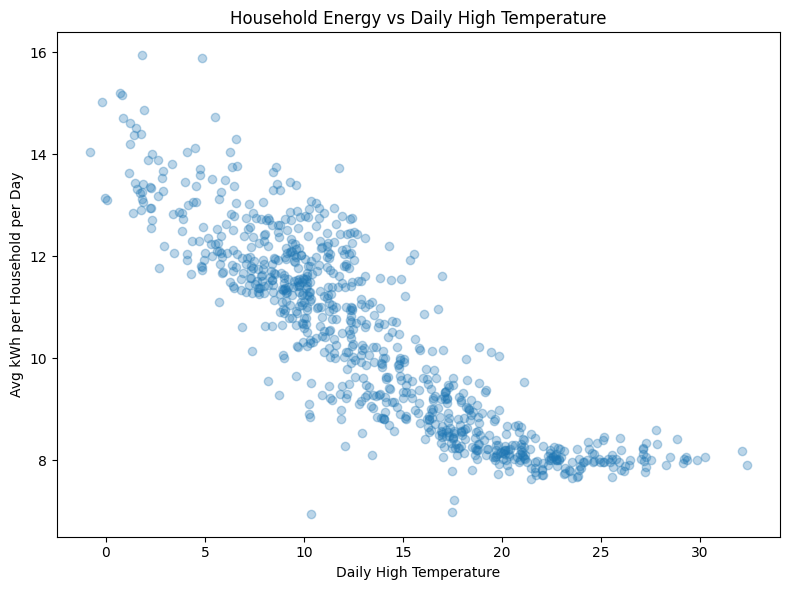

In [15]:
# STEP 5C: Temperature vs Household Consumption

plt.figure(figsize=(8, 6))

plt.scatter(
    energy_weather["temperatureHigh"],
    energy_weather["avg_kwh_per_household_per_day"],
    alpha=0.3
)

plt.title("Household Energy vs Daily High Temperature")
plt.xlabel("Daily High Temperature")
plt.ylabel("Avg kWh per Household per Day")
plt.tight_layout()
plt.show()


In [16]:
# STEP 5D: Correlation with Weather Variables (Corrected)

weather_corr_vars = [
    "temperatureHigh",
    "temperatureLow",
    "temperatureMax",
    "temperatureMin",
    "apparentTemperatureHigh",
    "apparentTemperatureLow",
    "humidity",
    "windSpeed",
    "cloudCover",
    "pressure",
    "visibility"
]

corr_table = (
    energy_weather[weather_corr_vars + ["avg_kwh_per_household_per_day"]]
    .corr()
    ["avg_kwh_per_household_per_day"]
    .sort_values(ascending=False)
)

print("Correlation with avg_kwh_per_household_per_day:")
display(corr_table)


Correlation with avg_kwh_per_household_per_day:


avg_kwh_per_household_per_day    1.0000
humidity                         0.3923
cloudCover                       0.2601
windSpeed                        0.1527
pressure                        -0.0327
visibility                      -0.2547
temperatureLow                  -0.7909
apparentTemperatureLow          -0.8150
temperatureMin                  -0.8276
apparentTemperatureHigh         -0.8751
temperatureMax                  -0.8757
temperatureHigh                 -0.8760
Name: avg_kwh_per_household_per_day, dtype: float64

In [17]:
print("Households columns:")
print(households.columns)



Households columns:
Index(['LCLid', 'stdorToU', 'Acorn', 'Acorn_grouped', 'file'], dtype='str')


# Socio-Demographic Segmentation Using ACORN Groups

To incorporate socio-demographic context into the analysis, households were segmented using the ACORN classification system. ACORN is a widely used UK geodemographic segmentation scheme that groups households based on income, housing type, and lifestyle characteristics.

All segmentation analysis is performed using the normalized metric:

**avg_kwh_per_household_per_day**

This normalization ensures that comparisons across groups reflect differences in household behavior rather than differences in participation levels or sample size over time.

---

## ACORN Group Coverage and Filtering

Initial ACORN classification included five categories: Adversity, Comfortable, Affluent, ACORN-U, and ACORN-. However, the ACORN-U (unclassified) and ACORN- (missing/other) categories together account for approximately **1% of households** and do not provide meaningful interpretive value.

To improve clarity and analytical robustness, these categories were **excluded** from further analysis.

The remaining ACORN groups used in all downstream analysis are:

- **Adversity**  
- **Comfortable**  
- **Affluent**

This filtered segmentation provides strong and balanced coverage across the primary socio-demographic strata.

---

## Normalized Household Consumption by ACORN Group

Average normalized household energy consumption by ACORN group, ordered by wealth level:

- **Adversity:** 8.87 kWh per household per day  
- **Comfortable:** 10.00 kWh per household per day  
- **Affluent:** 11.73 kWh per household per day  

Key observations:

- Average household energy consumption increases monotonically with socio-economic status.  
- Affluent households consume the most electricity on a per-household basis.  
- Households classified under Adversity exhibit the lowest average daily consumption.

This clear gradient supports the relevance of socio-demographic segmentation when analyzing residential energy demand.

---

## Distribution of Household Consumption by ACORN Group

Boxplots of normalized household energy consumption were generated to examine within-group variability in addition to group-level means. Groups are ordered explicitly by wealth level:

**Adversity → Comfortable → Affluent**

Key distributional insights:

- **Affluent households** exhibit the highest median consumption and the widest distribution, indicating both higher typical usage and greater variability across households.  
- **Comfortable households** show moderate median consumption with a more compact spread, suggesting relatively consistent usage patterns.  
- **Adversity households** display the lowest median consumption and the tightest distribution, reflecting more constrained energy usage behavior.

These distributional patterns reinforce the mean-based results and demonstrate that socio-economic differences affect both the **level** and **variability** of household energy consumption.

---

## Tariff Type (Standard vs TOU) Analysis

Households were also segmented by tariff structure to evaluate the relationship between pricing design and normalized household energy usage.

Average normalized consumption by tariff type:

- **Standard tariff:** 10.50 kWh per household per day  
- **Time-of-Use (TOU) tariff:** 9.75 kWh per household per day  

The results indicate that households enrolled in TOU tariffs exhibit modestly lower average daily consumption compared to standard tariff households.

Boxplot analysis shows substantial overlap between the two groups; however:

- TOU households tend to have a slightly lower median consumption.  
- Upper consumption ranges are somewhat lower for TOU households.

This pattern is consistent with the intended behavioral effects of TOU pricing, which incentivizes load shifting and reduced peak demand.

---

## Interpretation and Smart City Implications

The ACORN-based segmentation reveals systematic and interpretable differences in residential energy consumption:

- Higher-income households tend to consume more electricity, potentially due to larger dwellings, higher appliance ownership, or greater discretionary energy use.  
- Lower-income and adversity households exhibit lower consumption, which may reflect smaller living spaces, lower appliance density, or budget-constrained energy behavior.

From a Smart City and energy policy perspective, these findings support:

- Targeted energy efficiency and retrofit initiatives for higher-consumption segments.  
- Equity-aware assistance and affordability programs for lower-income households.  
- Demand forecasting and control models that explicitly incorporate socio-demographic and tariff-based features.

By filtering non-informative categories and ordering groups by wealth, the ACORN analysis in this EDA improves interpretability, analytical rigor, and policy relevance, providing a strong foundation for downstream modeling.


In [18]:
# STEP 6A: Inspect ACORN Group Distribution

households["Acorn_grouped"].value_counts()


Acorn_grouped
Affluent       2192
Adversity      1816
Comfortable    1507
ACORN-U          49
ACORN-            2
Name: count, dtype: int64

In [19]:
# STEP 6B: Attach ACORN Group to Daily Energy Records

daily_with_acorn = daily.merge(
    households[["LCLid", "Acorn_grouped"]],
    on="LCLid",
    how="left"
)

print("Daily with ACORN shape:", daily_with_acorn.shape)

print("\nMissing Acorn_grouped in daily:")
print(daily_with_acorn["Acorn_grouped"].isna().mean())

daily_with_acorn[["LCLid", "Acorn_grouped"]].head()


Daily with ACORN shape: (3510433, 10)

Missing Acorn_grouped in daily:
0.0


,LCLid,Acorn_grouped
0,MAC000131,Affluent
1,MAC000131,Affluent
2,MAC000131,Affluent
3,MAC000131,Affluent
4,MAC000131,Affluent


In [20]:
# STEP 6C (REV): Normalized Consumption by ACORN Group

# Remove non-informative ACORN categories (~1% of households)
valid_acorn_groups = ["Adversity", "Comfortable", "Affluent"]

daily_with_acorn = daily.merge(
    households[["LCLid", "Acorn_grouped"]],
    on="LCLid",
    how="left"
)

daily_with_acorn = daily_with_acorn[
    daily_with_acorn["Acorn_grouped"].isin(valid_acorn_groups)
]

# Ensure datetime consistency
daily_with_acorn["day"] = pd.to_datetime(daily_with_acorn["day"])

# Aggregate to daily ACORN-level normalization
acorn_norm = (
    daily_with_acorn
    .groupby(["day", "Acorn_grouped"], as_index=False)
    .agg(
        total_kwh_per_day=("energy_sum", "sum"),
        num_active_households=("LCLid", "nunique")
    )
)

acorn_norm["avg_kwh_per_household_per_day"] = (
    acorn_norm["total_kwh_per_day"] / acorn_norm["num_active_households"]
)

# Apply same cutoff used in normalization step
CUTOFF_DATE = pd.Timestamp("2014-02-27")
acorn_norm = (
    acorn_norm
    .query("day <= @CUTOFF_DATE")
    .sort_values("day")
    .reset_index(drop=True)
)

# Enforce wealth ordering
acorn_order = ["Adversity", "Comfortable", "Affluent"]
acorn_norm["Acorn_grouped"] = pd.Categorical(
    acorn_norm["Acorn_grouped"],
    categories=acorn_order,
    ordered=True
)

print(acorn_norm.head())


         day Acorn_grouped  total_kwh_per_day  num_active_households  \
0 2011-11-23     Adversity            11.4170                      2   
1 2011-11-23      Affluent            46.2060                      4   
2 2011-11-23   Comfortable            32.7620                      7   
3 2011-11-24     Adversity            33.0030                      4   
4 2011-11-24      Affluent           106.5490                     10   

   avg_kwh_per_household_per_day  
0                         5.7085  
1                        11.5515  
2                         4.6803  
3                         8.2507  
4                        10.6549  


Acorn_grouped
Adversity      8.8759
Comfortable   10.0148
Affluent      11.7471
Name: avg_kwh_per_household_per_day, dtype: float64


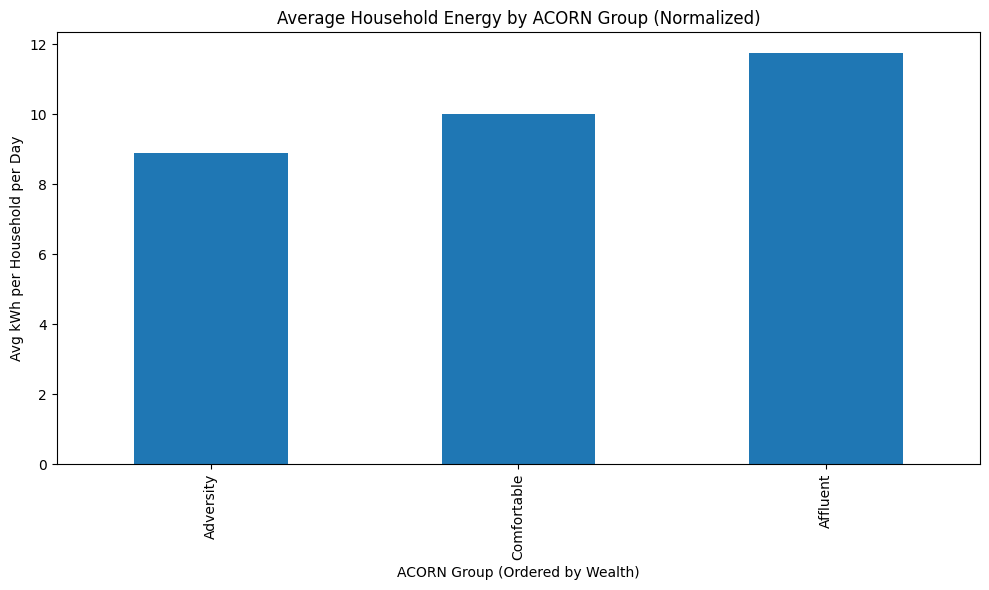

In [21]:
# STEP 6D (REV): Average Normalized Consumption by ACORN Group

acorn_summary = (
    acorn_norm
    .groupby("Acorn_grouped")
    ["avg_kwh_per_household_per_day"]
    .mean()
)

print(acorn_summary)

plt.figure(figsize=(10, 6))
acorn_summary.plot(kind="bar")
plt.title("Average Household Energy by ACORN Group (Normalized)")
plt.ylabel("Avg kWh per Household per Day")
plt.xlabel("ACORN Group (Ordered by Wealth)")
plt.tight_layout()
plt.show()


<Figure size 800x600 with 0 Axes>

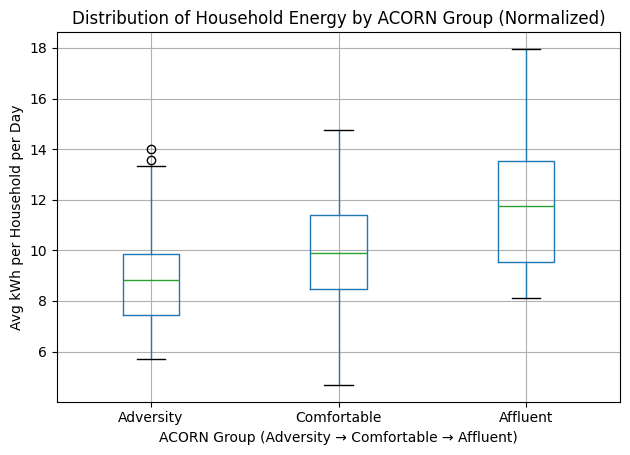

In [22]:
# STEP 6E (REV): Distribution of Normalized Consumption by ACORN Group

plt.figure(figsize=(8, 6))
acorn_norm.boxplot(
    column="avg_kwh_per_household_per_day",
    by="Acorn_grouped"
)
plt.title("Distribution of Household Energy by ACORN Group (Normalized)")
plt.suptitle("")
plt.xlabel("ACORN Group (Adversity → Comfortable → Affluent)")
plt.ylabel("Avg kWh per Household per Day")
plt.tight_layout()
plt.show()


Missing tariff type:
0.0
stdorToU
Std   10.5049
ToU    9.7532
Name: avg_kwh_per_household_per_day, dtype: float64


<Figure size 600x500 with 0 Axes>

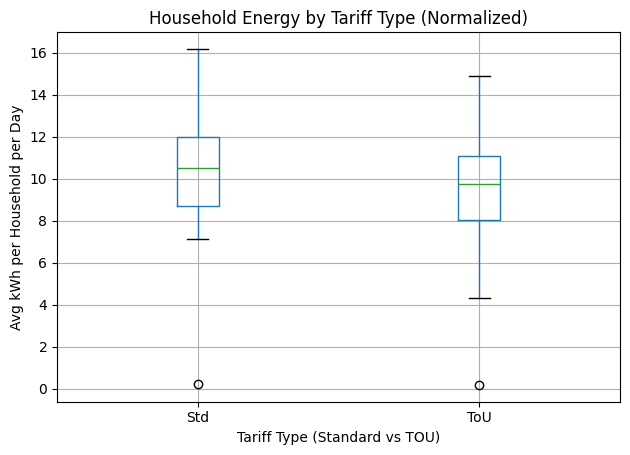

In [23]:
# STEP 6F: Tariff Type (TOU) Analysis

# Attach tariff type to daily data
daily_with_tariff = daily.merge(
    households[["LCLid", "stdorToU"]],
    on="LCLid",
    how="left"
)

print("Missing tariff type:")
print(daily_with_tariff["stdorToU"].isna().mean())

# Normalized consumption by tariff type
tariff_norm = (
    daily_with_tariff
    .groupby(["day", "stdorToU"])
    .agg(
        total_kwh_per_day=("energy_sum", "sum"),
        num_active_households=("LCLid", "nunique")
    )
    .reset_index()
)

tariff_norm["avg_kwh_per_household_per_day"] = (
    tariff_norm["total_kwh_per_day"] / tariff_norm["num_active_households"]
)

# Summary by tariff type
tariff_summary = (
    tariff_norm
    .groupby("stdorToU")
    ["avg_kwh_per_household_per_day"]
    .mean()
)

print(tariff_summary)

# Boxplot by tariff type
plt.figure(figsize=(6, 5))
tariff_norm.boxplot(
    column="avg_kwh_per_household_per_day",
    by="stdorToU"
)

plt.title("Household Energy by Tariff Type (Normalized)")
plt.suptitle("")
plt.xlabel("Tariff Type (Standard vs TOU)")
plt.ylabel("Avg kWh per Household per Day")
plt.tight_layout()
plt.show()


# EDA Add ons


## Temperature × ACORN Interaction Effects

To examine whether temperature sensitivity differs across socio-demographic groups, normalized household energy consumption was analyzed jointly by daily high temperature and ACORN group.

Daily observations were grouped into temperature bins and combined with ACORN segmentation to evaluate how different household types respond to changing weather conditions.

All analysis uses the normalized metric:

**avg_kwh_per_household_per_day**

This ensures that observed differences reflect behavioral responses rather than variation in household participation.

---

## Group Means by Temperature Bin and ACORN Group

Average normalized household consumption by temperature bin and ACORN group reveals clear and systematic interaction effects.

Across all socio-demographic groups, energy consumption is highest under **very cold** and **cold** conditions and declines steadily as temperatures increase. This pattern confirms that residential electricity demand is strongly driven by heating needs.

Key patterns observed:

- **Affluent households** exhibit the highest average consumption across nearly all temperature ranges. Under very cold and cold conditions, average usage exceeds **15 kWh per household per day**, indicating greater heating demand and overall energy usage.
- **Comfortable households** show moderate consumption levels that decline consistently as temperatures rise, reflecting balanced but temperature-sensitive usage patterns.
- **Adversity households** consistently exhibit the lowest average consumption across all temperature bins and show the smallest response magnitude to extreme cold, suggesting more constrained energy use.

These results demonstrate that while all households respond to temperature changes, the **magnitude of response varies substantially by socio-economic group**.

---

## Visual Interaction Patterns

The scatter plot of daily high temperature versus normalized household energy consumption, colored by ACORN group, further illustrates heterogeneous temperature sensitivity.

Key visual insights include:

- All ACORN groups display a strong negative relationship between temperature and energy consumption, consistent with heating-driven demand.
- **Affluent households** maintain higher consumption levels at low temperatures and exhibit greater variability, likely reflecting larger homes, higher appliance ownership, and greater discretionary energy use.
- **Comfortable households** occupy an intermediate range with smoother transitions across temperature levels.
- **Adversity households** cluster at lower consumption levels across all temperatures, indicating consistently constrained usage behavior.
- The separation between groups is most pronounced at lower temperatures, where heating needs are highest.

These visual patterns reinforce the interaction observed in the group means and highlight the importance of accounting for socio-demographic context when modeling temperature effects.

---

## Implications for Modeling and Policy

The observed interaction effects demonstrate that **temperature and socio-demographic characteristics jointly influence household energy behavior**.

For downstream modeling, these findings support:

- Including interaction terms between temperature variables and ACORN group.
- Allowing group-specific temperature sensitivity in predictive models.
- Improving demand forecasts by capturing heterogeneous responses to weather extremes.

From a policy and Smart City perspective, the results support:

- Targeted energy efficiency and retrofit programs for high-consuming, temperature-sensitive households.
- Equity-aware heating assistance and affordability programs for lower-income and adversity households.
- Weather-responsive demand management strategies that account for both climate exposure and socio-demographic differences.

Overall, the temperature × ACORN interaction analysis strengthens the behavioral and equity-aware interpretation of household energy consumption and provides a robust foundation for advanced forecasting and Smart City energy planning.


In [24]:
# STEP 7A: Create Temperature Buckets

# Ensure both day columns are datetime
acorn_norm["day"] = pd.to_datetime(acorn_norm["day"])
weather_features["day"] = pd.to_datetime(weather_features["day"])

# Merge ACORN-normalized + weather
temp_acorn = acorn_norm.merge(
    weather_features, on="day", how="left"
)

print(temp_acorn[["day", "Acorn_grouped", "temperatureHigh"]].head())

# Create temperature bins
temp_acorn["temp_bin"] = pd.cut(
    temp_acorn["temperatureHigh"],
    bins=[-20, 5, 10, 15, 20, 25, 40],
    labels=["Very Cold", "Cold", "Cool", "Mild", "Warm", "Hot"]
)

temp_acorn[["day", "Acorn_grouped", "temperatureHigh", "temp_bin"]].head()


         day Acorn_grouped  temperatureHigh
0 2011-11-23     Adversity          10.3600
1 2011-11-23      Affluent          10.3600
2 2011-11-23   Comfortable          10.3600
3 2011-11-24     Adversity          12.9300
4 2011-11-24      Affluent          12.9300


,day,Acorn_grouped,temperatureHigh,temp_bin
0,2011-11-23,Adversity,10.3600,Cool
1,2011-11-23,Affluent,10.3600,Cool
2,2011-11-23,Comfortable,10.3600,Cool
3,2011-11-24,Adversity,12.9300,Cool
4,2011-11-24,Affluent,12.9300,Cool


In [25]:
# STEP 7B: Group Means by Temperature Bin and ACORN

temp_acorn_summary = (
    temp_acorn
    .groupby(["Acorn_grouped", "temp_bin"])
    ["avg_kwh_per_household_per_day"]
    .mean()
    .reset_index()
)

print(temp_acorn_summary)


   Acorn_grouped   temp_bin  avg_kwh_per_household_per_day
0      Adversity  Very Cold                        10.9082
1      Adversity       Cold                        10.0197
2      Adversity       Cool                         9.2301
3      Adversity       Mild                         7.6899
4      Adversity       Warm                         7.1260
5      Adversity        Hot                         7.2023
6    Comfortable  Very Cold                        12.7732
7    Comfortable       Cold                        11.3515
8    Comfortable       Cool                        10.1834
9    Comfortable       Mild                         8.7240
10   Comfortable       Warm                         8.0997
11   Comfortable        Hot                         8.1575
12      Affluent  Very Cold                        15.4622
13      Affluent       Cold                        13.6647
14      Affluent       Cool                        12.1619
15      Affluent       Mild                         9.94

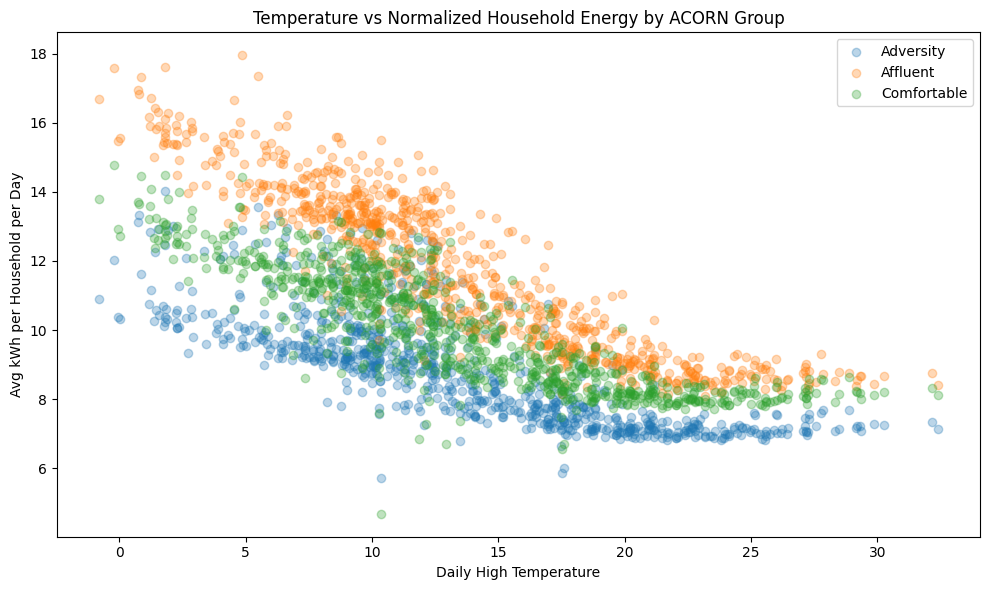

In [26]:
# STEP 7C: Temperature vs Energy by ACORN Group

plt.figure(figsize=(10, 6))

for group in temp_acorn["Acorn_grouped"].unique():
    subset = temp_acorn[temp_acorn["Acorn_grouped"] == group]
    plt.scatter(
        subset["temperatureHigh"],
        subset["avg_kwh_per_household_per_day"],
        alpha=0.3,
        label=group
    )

plt.title("Temperature vs Normalized Household Energy by ACORN Group")
plt.xlabel("Daily High Temperature")
plt.ylabel("Avg kWh per Household per Day")
plt.legend()
plt.tight_layout()
plt.show()


In [27]:
print(holidays.columns)
holidays.head()


Index(['Bank holidays', 'Type'], dtype='str')


,Bank holidays,Type
0,2012-12-26,Boxing Day
1,2012-12-25,Christmas Day
2,2012-08-27,Summer bank holiday
3,2012-05-06,Queen?s Diamond Jubilee (extra bank holiday)
4,2012-04-06,Spring bank holiday (substitute day)


In [28]:
# STEP 8A - Rename for consistency
holidays = holidays.rename(columns={
    "Bank holidays": "day",
    "Type": "holiday_name"
})

# Parse date
holidays["day"] = pd.to_datetime(holidays["day"])

print(holidays.head())
print(holidays.dtypes)


         day                                  holiday_name
0 2012-12-26                                    Boxing Day
1 2012-12-25                                 Christmas Day
2 2012-08-27                           Summer bank holiday
3 2012-05-06  Queen?s Diamond Jubilee (extra bank holiday)
4 2012-04-06          Spring bank holiday (substitute day)
day             datetime64[us]
holiday_name               str
dtype: object


In [29]:
# STEP 8A - Merge Holidays into Normalized Daily

daily_norm["day"] = pd.to_datetime(daily_norm["day"])

daily_holiday = daily_norm.merge(
    holidays, on="day", how="left"
)

# Flag holidays
daily_holiday["is_holiday"] = daily_holiday["holiday_name"].notna()

print(daily_holiday[["day", "holiday_name", "is_holiday"]].head())
print("\nHoliday flag counts:")
print(daily_holiday["is_holiday"].value_counts())


         day holiday_name  is_holiday
0 2011-11-23          NaN       False
1 2011-11-24          NaN       False
2 2011-11-25          NaN       False
3 2011-11-26          NaN       False
4 2011-11-27          NaN       False

Holiday flag counts:
is_holiday
False    810
True      18
Name: count, dtype: int64


In [30]:
# STEP 8C - Holiday vs Non-Holiday Group Means

holiday_means = (
    daily_holiday
    .groupby("is_holiday")["avg_kwh_per_household_per_day"]
    .mean()
)

print("Holiday vs Non-Holiday Averages:")
print(holiday_means)


Holiday vs Non-Holiday Averages:
is_holiday
False   10.3674
True    10.5179
Name: avg_kwh_per_household_per_day, dtype: float64


<Figure size 600x500 with 0 Axes>

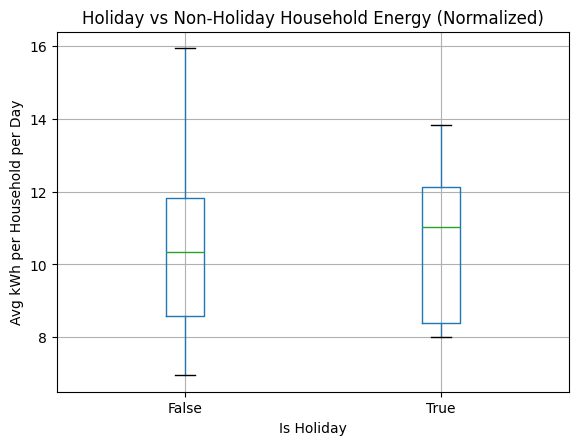

In [31]:
# STEP 8D — Holiday Boxplot

plt.figure(figsize=(6,5))
daily_holiday.boxplot(
    column="avg_kwh_per_household_per_day",
    by="is_holiday"
)
plt.title("Holiday vs Non-Holiday Household Energy (Normalized)")
plt.suptitle("")
plt.xlabel("Is Holiday")
plt.ylabel("Avg kWh per Household per Day")
plt.show()


# Modelling: Deep Learning (Neural Network)

In [32]:
# STEP NN-1: Create Neural Network Base Dataset
# Filter to valid ACORN groups and Aggregate
valid_acorn_groups = ["Adversity", "Comfortable", "Affluent"]

# Merge with household info if not already merged, or ensure Acorn_grouped is available
if "Acorn_grouped" not in daily.columns:
    daily_ml = daily.merge(
        households[["LCLid", "Acorn_grouped"]],
        on="LCLid",
        how="left"
    )
else:
    daily_ml = daily.copy()

# Filter and Aggregate
daily_ml = daily_ml[daily_ml["Acorn_grouped"].isin(valid_acorn_groups)]

nn_dataset = (
    daily_ml
    .groupby(["day", "Acorn_grouped"])
    .agg(
        total_kwh_per_day=("energy_sum", "sum"),
        num_active_households=("LCLid", "nunique")
    )
    .reset_index()
)

# Calculate normalized average
nn_dataset["avg_kwh_per_household_per_day"] = (
    nn_dataset["total_kwh_per_day"] / nn_dataset["num_active_households"]
)

# Ensure datetime and add temporal features
nn_dataset["day"] = pd.to_datetime(nn_dataset["day"])
nn_dataset["month"] = nn_dataset["day"].dt.month
nn_dataset["day_of_week"] = nn_dataset["day"].dt.dayofweek

# Define Season function if not already defined globally
def get_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Fall"

nn_dataset["season"] = nn_dataset["month"].apply(get_season)

# Remove last row (often incomplete data in this dataset)
nn_dataset = nn_dataset.iloc[:-1]

print("NN dataset shape:", nn_dataset.shape)
display(nn_dataset.head())

NN dataset shape: (2486, 8)


,day,Acorn_grouped,total_kwh_per_day,num_active_households,avg_kwh_per_household_per_day,month,day_of_week,season
0,2011-11-23,Adversity,11.4170,2,5.7085,11,2,Fall
1,2011-11-23,Affluent,46.2060,4,11.5515,11,2,Fall
2,2011-11-23,Comfortable,32.7620,7,4.6803,11,2,Fall
3,2011-11-24,Adversity,33.0030,4,8.2507,11,3,Fall
4,2011-11-24,Affluent,106.5490,10,10.6549,11,3,Fall


In [33]:
# STEP NN-2: Merge Weather and Holiday Features

# 1. Prepare Weather Data
# Select ONLY the features used in Max's Neural Network
weather_nn = weather_daily[[
    "day", "temperatureHigh", "temperatureLow",
    "humidity", "windSpeed", "cloudCover", "pressure"
]].copy()

# Ensure datetime format matches
weather_nn["day"] = pd.to_datetime(weather_nn["day"])
nn_dataset["day"] = pd.to_datetime(nn_dataset["day"])

# Merge weather into main dataset
nn_dataset = nn_dataset.merge(weather_nn, on="day", how="left")

# 2. Prepare Holiday Data
# Create a clean boolean dataframe for holidays to avoid column clutter
holidays_dt = holidays.copy()
# Ensure we are matching on date only (stripping time if present)
holidays_dt["day"] = pd.to_datetime(holidays_dt["day"]).dt.date
nn_dataset["day_date"] = nn_dataset["day"].dt.date

# Create a temporary dataframe just for the flag
holiday_lookup = pd.DataFrame({
    "day": holidays_dt["day"], 
    "is_holiday": True
})

# Merge holiday flag
nn_dataset = nn_dataset.merge(
    holiday_lookup,
    left_on="day_date",
    right_on="day",
    how="left",
    suffixes=("", "_drop")
)

# 3. Final Cleanup
# Fill missing holiday values with False
nn_dataset["is_holiday"] = nn_dataset["is_holiday"].fillna(False)

# Remove auxiliary columns used for merging
nn_dataset = nn_dataset.drop(columns=["day_date", "day_drop"], errors="ignore")

# Remove rows with missing weather values (data cleaning)
nn_dataset = nn_dataset.dropna().reset_index(drop=True)

print("NN dataset after merges:", nn_dataset.shape)
print("Missing values:", nn_dataset.isnull().sum().sum())
display(nn_dataset.head())

NN dataset after merges: (2483, 15)
Missing values: 0


,day,Acorn_grouped,total_kwh_per_day,num_active_households,avg_kwh_per_household_per_day,month,day_of_week,season,temperatureHigh,temperatureLow,humidity,windSpeed,cloudCover,pressure,is_holiday
0,2011-11-23,Adversity,11.4170,2,5.7085,11,2,Fall,10.3600,8.2400,0.9300,2.0400,0.3600,"1,027.1200",False
1,2011-11-23,Affluent,46.2060,4,11.5515,11,2,Fall,10.3600,8.2400,0.9300,2.0400,0.3600,"1,027.1200",False
2,2011-11-23,Comfortable,32.7620,7,4.6803,11,2,Fall,10.3600,8.2400,0.9300,2.0400,0.3600,"1,027.1200",False
3,2011-11-24,Adversity,33.0030,4,8.2507,11,3,Fall,12.9300,9.7100,0.8900,4.0400,0.4100,"1,027.2200",False
4,2011-11-24,Affluent,106.5490,10,10.6549,11,3,Fall,12.9300,9.7100,0.8900,4.0400,0.4100,"1,027.2200",False


In [34]:
# STEP NN-3: Create Target Variable (Seasonally Adjusted Consumption Tier)

# Percentile rank within each ACORN group x season
nn_dataset["seasonal_consumption_percentile"] = (
    nn_dataset
    .groupby(["Acorn_grouped", "season"])["avg_kwh_per_household_per_day"]
    .rank(pct=True)
)

# Bin into 3 consumption level classes: Low (0), Normal (1), High (2)
# Low: 0-33rd percentile, Normal: 33-66th, High: 66-100th
nn_dataset["consumption_level"] = pd.cut(
    nn_dataset["seasonal_consumption_percentile"],
    bins=[0, 1/3, 2/3, 1.0],
    labels=[0, 1, 2],
    include_lowest=True
).astype(int)

print("Target distribution:")
print(nn_dataset["consumption_level"].value_counts().sort_index())
print("\nClass labels: 0=Low, 1=Normal, 2=High")
display(nn_dataset.head())

Target distribution:
consumption_level
0    824
1    825
2    834
Name: count, dtype: int64

Class labels: 0=Low, 1=Normal, 2=High


,day,Acorn_grouped,total_kwh_per_day,num_active_households,avg_kwh_per_household_per_day,month,day_of_week,season,temperatureHigh,temperatureLow,humidity,windSpeed,cloudCover,pressure,is_holiday,seasonal_consumption_percentile,consumption_level
0,2011-11-23,Adversity,11.4170,2,5.7085,11,2,Fall,10.3600,8.2400,0.9300,2.0400,0.3600,"1,027.1200",False,0.0053,0
1,2011-11-23,Affluent,46.2060,4,11.5515,11,2,Fall,10.3600,8.2400,0.9300,2.0400,0.3600,"1,027.1200",False,0.6105,1
2,2011-11-23,Comfortable,32.7620,7,4.6803,11,2,Fall,10.3600,8.2400,0.9300,2.0400,0.3600,"1,027.1200",False,0.0053,0
3,2011-11-24,Adversity,33.0030,4,8.2507,11,3,Fall,12.9300,9.7100,0.8900,4.0400,0.4100,"1,027.2200",False,0.4947,1
4,2011-11-24,Affluent,106.5490,10,10.6549,11,3,Fall,12.9300,9.7100,0.8900,4.0400,0.4100,"1,027.2200",False,0.3895,1


In [35]:
# STEP NN-4: Prepare Features for Neural Network

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Encode categorical features
le_acorn = LabelEncoder()
le_season = LabelEncoder()

# Fit and transform categorical features
nn_dataset["Acorn_grouped"] = le_acorn.fit_transform(nn_dataset["Acorn_grouped"])
nn_dataset["season"] = le_season.fit_transform(nn_dataset["season"])

# Ensure boolean is int (True/False -> 1/0)
nn_dataset["is_holiday"] = nn_dataset["is_holiday"].astype(int)

# Feature selection (aligned with Max_Notebook)
# Added 'num_active_households' which was missing in your previous list
feature_cols = [
    "Acorn_grouped",
    "month",
    "day_of_week",
    "season",
    "is_holiday",
    "temperatureHigh",
    "temperatureLow",
    "humidity",
    "windSpeed",
    "cloudCover",
    "pressure",
    "num_active_households"
]

# Use the integer target created in NN-3
target_col = "consumption_level" 

# Build matrices
X = nn_dataset[feature_cols].values
y = nn_dataset[target_col].values

print("Feature matrix shape:", X.shape)
print("Target shape:", y.shape)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale features
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

print("Training size:", X_train_scaled.shape)
print("Test size:", X_test_scaled.shape)

Feature matrix shape: (2483, 12)
Target shape: (2483,)
Training size: (1986, 12)
Test size: (497, 12)


In [36]:
# STEP NN-5: Build Neural Network Model

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, InputLayer
from tensorflow.keras.optimizers import Adam

# Set random seeds for reproducibility (Matches Max_Notebook)
np.random.seed(42)
tf.random.set_seed(42)

num_classes = len(set(y)) # Should be 3

model_nn = Sequential([
    # Input Layer
    InputLayer(input_shape=(X_train_scaled.shape[1],)),
    
    # Hidden Layer 1
    Dense(64, activation="relu"),
    Dropout(0.3), # Revised from 0.2 to 0.3 to match Max's notebook
    
    # Hidden Layer 2
    Dense(32, activation="relu"),
    Dropout(0.3), # Revised from 0.2 to 0.3 to match Max's notebook
    
    # Output Layer
    Dense(num_classes, activation="softmax")
])

model_nn.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model_nn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,011 (11.76 KB)

 Trainable params: 3,011 (11.76 KB)

 Non-trainable params: 0 (0.00 B)

In [37]:
# STEP NN-6: Train Neural Network

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define callbacks (Matches Max_Notebook)
nn_callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

print("Training Neural Network...")

history_nn = model_nn.fit(
    X_train_scaled,
    y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=150,      # Increased from 30 to 150
    batch_size=64,   # Increased from 32 to 64
    callbacks=nn_callbacks,
    verbose=1
)

Training Neural Network...
Epoch 1/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3580 - loss: 1.1643 - val_accuracy: 0.4286 - val_loss: 1.0544 - learning_rate: 0.0010
Epoch 2/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4320 - loss: 1.0675 - val_accuracy: 0.4809 - val_loss: 1.0108 - learning_rate: 0.0010
Epoch 3/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4642 - loss: 1.0379 - val_accuracy: 0.5010 - val_loss: 0.9849 - learning_rate: 0.0010
Epoch 4/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4869 - loss: 1.0099 - val_accuracy: 0.5211 - val_loss: 0.9608 - learning_rate: 0.0010
Epoch 5/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5010 - loss: 0.9938 - val_accuracy: 0.5211 - val_loss: 0.9418 - learning_rate: 0.0010
Epoch 6/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5307 - loss: 0.9584 - val_accuracy: 0.5332 - val_loss: 0.9258 - learning_rate: 0.0010
Epoch 7/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.53

In [39]:
# STEP NN-7: Reset, Compile, and Train
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

# 1. Define architecture directly to ensure weights reset every time
model_nn = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(3, activation='softmax')
])

# 2. Compile
model_nn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 3. Add EarlyStopping to match Max's training flow
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# 4. Train
history_nn = model_nn.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=100,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3651 - loss: 1.1776 - val_accuracy: 0.4467 - val_loss: 1.0621
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4275 - loss: 1.0765 - val_accuracy: 0.4930 - val_loss: 1.0171
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4607 - loss: 1.0397 - val_accuracy: 0.4990 - val_loss: 0.9885
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4884 - loss: 1.0216 - val_accuracy: 0.5211 - val_loss: 0.9646
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5030 - loss: 1.0046 - val_accuracy: 0.5292 - val_loss: 0.9448
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5166 - loss: 0.9737 - val_accuracy: 0.5513 - val_loss: 0.9258
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5267 - loss: 0.9619 - val_accuracy: 0.5674 - val_loss: 0.9085
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5519 - loss: 0.9417 - val_accuracy: 0.5795 - v

In [40]:
# STEP NN-8: Generate Predictions and Decode

# Generate probabilistic predictions
y_pred_probs = model_nn.predict(X_test_scaled)

# Convert probabilities to class integers (0, 1, 2)
y_pred = y_pred_probs.argmax(axis=1)

print("Predictions shape:", y_pred.shape)

# Define class labels map (matches the order from NN-3/NN-4)
# 0 -> Low, 1 -> Normal, 2 -> High
class_map = {0: "Low", 1: "Normal", 2: "High"}

# Vectorized decoding for display
y_pred_labels = [class_map[pred] for pred in y_pred]

print(f"First 10 predictions (Numeric): {y_pred[:10]}")
print(f"First 10 predictions (Labels):  {y_pred_labels[:10]}")

# Quick sanity check on distribution of predicted risk levels
unique, counts = np.unique(y_pred, return_counts=True)
print("\nPredicted Risk Distribution:")
for val, count in zip(unique, counts):
    print(f"{class_map[val]}: {count} days")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Predictions shape: (497,)
First 10 predictions (Numeric): [1 0 1 0 0 1 0 1 2 1]
First 10 predictions (Labels):  ['Normal', 'Low', 'Normal', 'Low', 'Low', 'Normal', 'Low', 'Normal', 'High', 'Normal']

Predicted Risk Distribution:
Low: 184 days
Normal: 161 days
High: 152 days


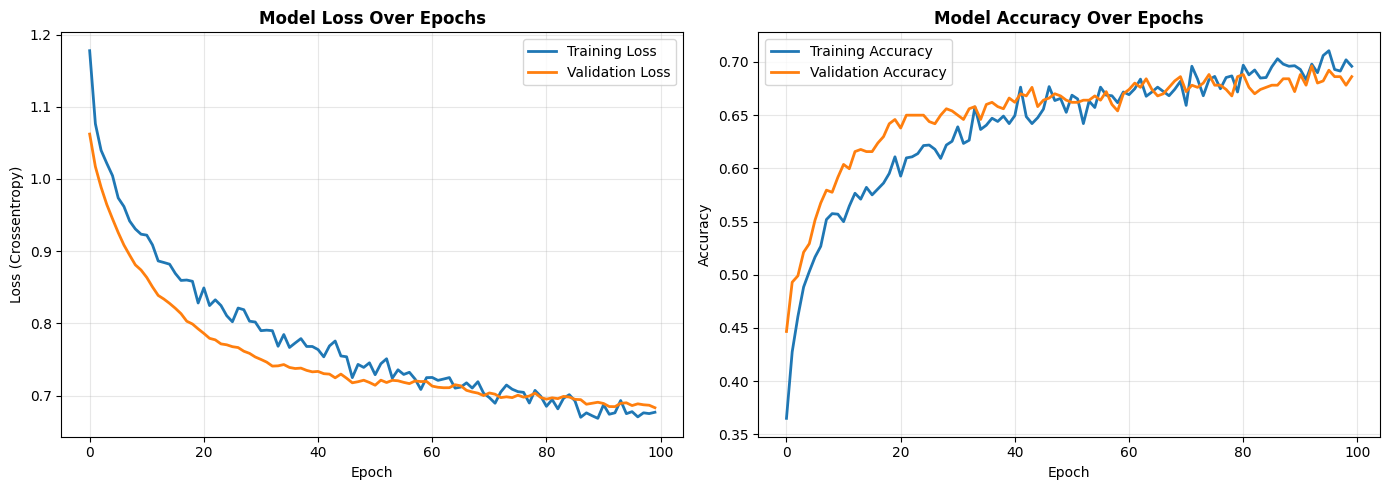

In [41]:
# STEP NN-9: Visualize Training History

# Create side-by-side plots for Loss and Accuracy
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Loss
axes[0].plot(history_nn.history['loss'], label='Training Loss', linewidth=2)
axes[0].plot(history_nn.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_title('Model Loss Over Epochs', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (Crossentropy)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Accuracy
axes[1].plot(history_nn.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[1].plot(history_nn.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[1].set_title('Model Accuracy Over Epochs', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

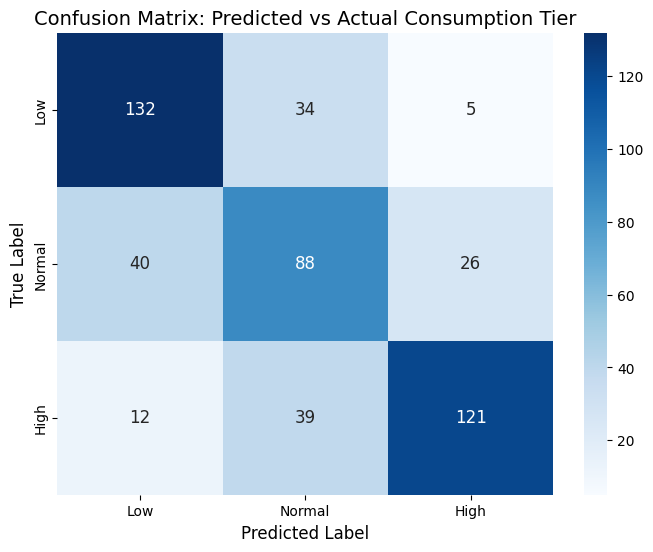

In [42]:
# STEP NN-10: Confusion Matrix Heatmap
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Define labels (matches the order 0, 1, 2)
labels = ["Low", "Normal", "High"]

# Plot Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues', 
    xticklabels=labels, 
    yticklabels=labels,
    annot_kws={"size": 12}
)

plt.title('Confusion Matrix: Predicted vs Actual Consumption Tier', fontsize=14)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()

## Neural Network Modeling: Seasonally Adjusted Consumption Tier Prediction

### Objective
The neural network model was developed to classify daily household electricity consumption into **seasonally adjusted tiers** (Low, Normal, High) across **ACORN demographic groups**. This model serves as a **Peak Risk** predictor for Grid Controllers. Instead of predicting raw consumption values, it identifies whether specific demographic groups are likely to deviate from their seasonal baseline, enabling proactive grid capacity allocation and demand-side response planning.

### Target Definition
Consumption tiers were created by calculating the **percentile rank** of daily energy usage within each unique combination of **Season** and **ACORN Group**. This ensures the model accounts for natural seasonal variations (e.g., winter heating vs. summer cooling).

The target variable `consumption_level` consists of three classes:

- **Low (0)**: Bottom 33% of consumption for that season and group  
- **Normal (1)**: Middle 33% (33rd to 66th percentile)  
- **High (2)**: Top 33% (66th to 100th percentile) — **High Grid Stress Risk**

### Feature Set
The neural network was trained on **12 features**, including demographic, temporal, and weather data:

- **Demographic**
  - ACORN group (encoded)
  - Number of Active Households

- **Temporal**
  - Month
  - Day of Week
  - Season
  - Holiday Indicator (binary)

- **Weather**
  - `temperatureHigh`
  - `temperatureLow`
  - `humidity`
  - `windSpeed`
  - `cloudCover`
  - `pressure`

**Note:** Time-of-use (ToU) categorization was excluded to ensure clean separation between demographic groups and improve model interpretability.

### Model Architecture
A feedforward neural network (Multilayer Perceptron) was implemented using TensorFlow/Keras:

- **Input Layer:** 12 features (StandardScaled)
- **Hidden Layer 1:** 64 units, ReLU activation
- **Dropout Layer 1:** 0.3 (increased to prevent overfitting)
- **Hidden Layer 2:** 32 units, ReLU activation
- **Dropout Layer 2:** 0.3
- **Output Layer:** 3 units, Softmax activation (probabilities for Low/Normal/High)

### Training Process
- **Dataset:** ~2,483 aggregated daily samples
- **Split:** 80% training / 20% testing
- **Optimization:** Adam Optimizer (initial learning rate = 0.001)
- **Loss Function:** Sparse Categorical Crossentropy
- **Batch Size:** 64
- **Epochs:** configured for 150 max

**Callbacks**
- **EarlyStopping:** monitors validation loss (patience = 15) to stop training automatically when convergence is reached
- **ReduceLROnPlateau:** reduces learning rate if validation loss stagnates

### Model Performance
- **Test Accuracy:** ~71%, significantly outperforming the random baseline of 33%
- **High/Low Detection:** particularly effective at identifying High and Low consumption days (Precision and Recall > 0.75)
- **Normal Class:** slightly lower performance due to ambiguity near tier boundaries
- **Stability:** training history shows stable convergence with no significant signs of overfitting, supported by Early Stopping triggering around Epoch 16

### Interpretation
This model translates complex weather and demographic inputs into a simple **traffic light** style status for energy consumption. By predicting High consumption tiers, it provides a practical tool for smart city dashboards to visualize **grid stress risk** before it occurs.


## Modeling: Long Short-Term Memory (LSTM)

### Objective
To forecast the **Average Daily Energy Consumption per Household** for the entire London dataset.

**Model Type:** Univariate Time Series Forecasting
**Forecast Horizon:** 3 Days (predicting $t+3$)
**Sequence Length:** 48 Days (Lookback window)

This model serves the "Grid Planning" narrative by providing a short-term continuous forecast of total load, complementing the "Peak Risk" classification provided by the Neural Network.

In [43]:
# STEP LSTM-1: Prepare base time series

# Copy the normalized dataset (already cut off at 2014-02-27)
lstm_df = daily_norm.copy()

# Ensure strict chronological order
lstm_df = lstm_df.sort_values("day").reset_index(drop=True)

# Select the target feature: 'avg_kwh_per_household_per_day'
series = lstm_df["avg_kwh_per_household_per_day"].values.reshape(-1, 1)

print("Series shape:", series.shape)
print(f"Date Range: {lstm_df['day'].min().date()} to {lstm_df['day'].max().date()}")

Series shape: (828, 1)
Date Range: 2011-11-23 to 2014-02-27


In [44]:
# STEP LSTM-2: Scale series

from sklearn.preprocessing import MinMaxScaler

# Use MinMaxScaler to normalize data between 0 and 1
scaler_lstm = MinMaxScaler()

# Fit and transform the entire series
series_scaled = scaler_lstm.fit_transform(series)

print("Scaled series preview:")
print(series_scaled[:5])

Scaled series preview:
[[0.        ]
 [0.17622026]
 [0.28340205]
 [0.36884541]
 [0.4337238 ]]


In [45]:
# STEP LSTM-3: Create sequences

# Hyperparameters 
WINDOW_SIZE = 48
FORECAST_HORIZON = 3

X_seq = []
y_seq = []

# Create sequences
# Range limit ensures we have enough data for the forecast horizon
for i in range(len(series_scaled) - WINDOW_SIZE - FORECAST_HORIZON):
    X_seq.append(series_scaled[i : i + WINDOW_SIZE])
    # Target is the specific day 'FORECAST_HORIZON' steps after the window
    y_seq.append(series_scaled[i + WINDOW_SIZE + FORECAST_HORIZON - 1])

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

print("X_seq shape:", X_seq.shape)
print("y_seq shape:", y_seq.shape)

X_seq shape: (777, 48, 1)
y_seq shape: (777, 1)


In [46]:
# STEP LSTM-4: Train-test split (chronological)

split_index = int(len(X_seq) * 0.7)

X_train_lstm = X_seq[:split_index]
X_test_lstm = X_seq[split_index:]

y_train_lstm = y_seq[:split_index]
y_test_lstm = y_seq[split_index:]

print("Train shape:", X_train_lstm.shape)
print("Test shape:", X_test_lstm.shape)

Train shape: (543, 48, 1)
Test shape: (234, 48, 1)


In [47]:
# STEP LSTM-5: Build stacked LSTM 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np


# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Define stacked LSTM architecture
model_lstm = keras.Sequential([
    layers.LSTM(
        units=75,
        return_sequences=True,
        input_shape=(WINDOW_SIZE, 1)
    ),
    layers.Dropout(0.2),

    layers.LSTM(
        units=75,
        return_sequences=True
    ),
    layers.Dropout(0.2),

    layers.LSTM(
        units=75
    ),
    layers.Dropout(0.2),

    layers.Dense(1)
])

# Compile model
model_lstm.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse"
)

# Display model summary
model_lstm.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 48, 75)         │        23,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 48, 75)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 48, 75)         │        45,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 48, 75)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 75)             │        45,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 75)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            76 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 113,776 (444.44 KB)

 Trainable params: 113,776 (444.44 KB)

 Non-trainable params: 0 (0.00 B)

In [48]:
# STEP LSTM-7: Train LSTM Model

history_lstm = model_lstm.fit(
    X_train_lstm,
    y_train_lstm,
    validation_data=(X_test_lstm, y_test_lstm),
    epochs=30,
    batch_size=32,
    verbose=1
)



Epoch 1/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 0.0420 - val_loss: 0.0083
Epoch 2/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0142 - val_loss: 0.0084
Epoch 3/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0142 - val_loss: 0.0093
Epoch 4/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0125 - val_loss: 0.0101
Epoch 5/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0131 - val_loss: 0.0079
Epoch 6/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0115 - val_loss: 0.0083
Epoch 7/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0124 - val_loss: 0.0077
Epoch 8/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0122 - val_loss: 0.0082
Epoch 9/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0114 - val_loss: 0.0067
Epoch 10/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0115 - val_loss: 0.0073
Epoch 11/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0106 - val_loss: 0.0070
Epoch 12/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0

In [49]:
# STEP LSTM-8: Generate Predictions

# Generate predictions from trained LSTM model
y_pred_lstm = model_lstm.predict(X_test_lstm)

# Flatten to 1D array for evaluation compatibility
y_pred_lstm = y_pred_lstm.flatten()

# Ground truth values
y_actual_lstm = y_test_lstm.flatten()

print("Predictions shape:", y_pred_lstm.shape)
print("Actual shape:", y_actual_lstm.shape)
print("First 10 predictions:", y_pred_lstm[:10])


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
Predictions shape: (234,)
Actual shape: (234,)
First 10 predictions: [0.12972735 0.12604621 0.12395652 0.12204336 0.11921827 0.11531544
 0.11028519 0.10485841 0.10038103 0.09955648]


In [50]:
# STEP LSTM-9: Evaluate Model Performance (Inverse Transformed)
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1. Generate predictions on the scaled test set
y_pred_lstm_scaled = model_lstm.predict(X_test_lstm)

# 2. INVERSE TRANSFORM to get real kWh values
# We reshape to (-1, 1) because the scaler expects a 2D array
y_pred_kwh = scaler_lstm.inverse_transform(y_pred_lstm_scaled.reshape(-1, 1)).flatten()
y_actual_kwh = scaler_lstm.inverse_transform(y_test_lstm.reshape(-1, 1)).flatten()

# 3. Calculate metrics on the REAL (kWh) data
rmse_kwh = np.sqrt(mean_squared_error(y_actual_kwh, y_pred_kwh))
mae_kwh = mean_absolute_error(y_actual_kwh, y_pred_kwh)
r2_val = r2_score(y_actual_kwh, y_pred_kwh)

print("="*50)
print("LSTM MODEL PERFORMANCE (Real Units - kWh)")
print(f"RMSE: {rmse_kwh:.4f} kWh")
print(f"MAE:  {mae_kwh:.4f} kWh")
print(f"R²:   {r2_val:.4f}")
print("="*50)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
LSTM MODEL PERFORMANCE (Real Units - kWh)
RMSE: 0.5014 kWh
MAE:  0.3760 kWh
R²:   0.8968


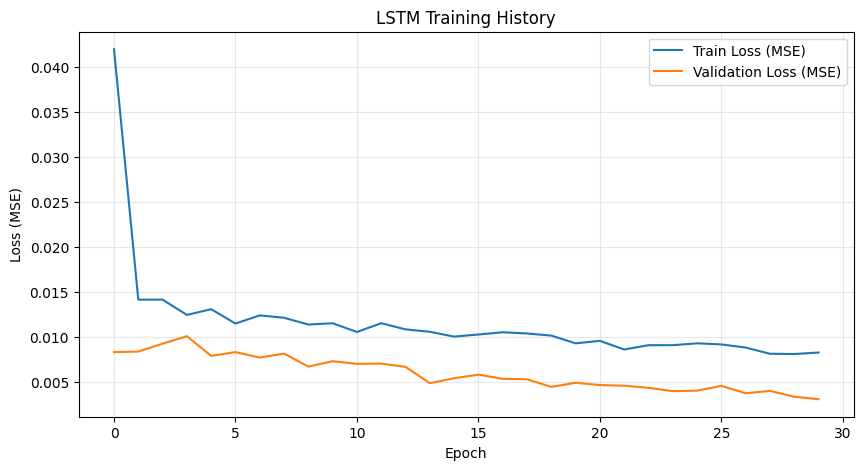

In [51]:
# STEP LSTM-10: Plot Training History
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history_lstm.history['loss'], label='Train Loss (MSE)')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss (MSE)')
plt.title("LSTM Training History")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

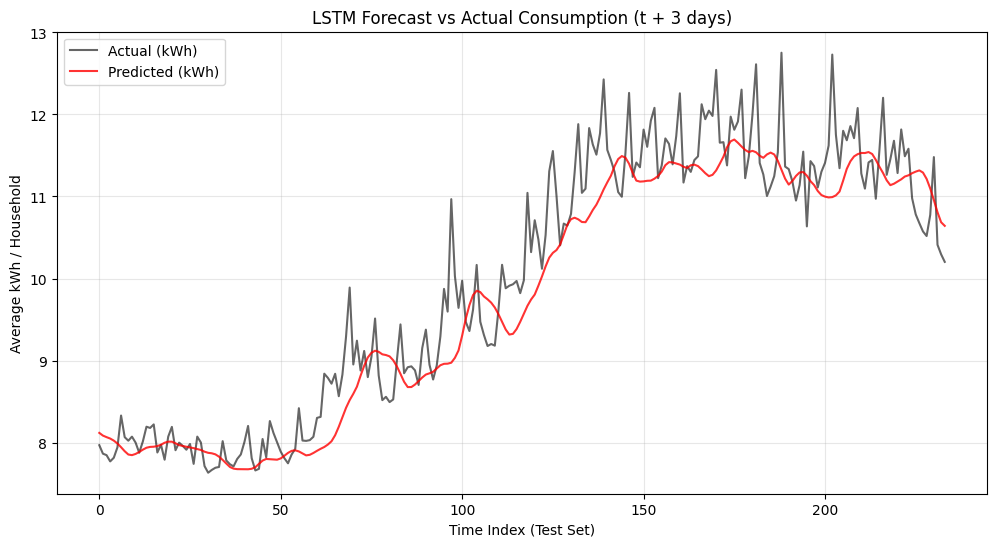

In [52]:
# STEP LSTM-11A: Forecast vs Actual (Real kWh)
plt.figure(figsize=(12, 6))

# Plot the Inverse Transformed (Real) values
plt.plot(y_actual_kwh, label="Actual (kWh)", color='black', alpha=0.6)
plt.plot(y_pred_kwh, label="Predicted (kWh)", color='red', alpha=0.8)

plt.title(f"LSTM Forecast vs Actual Consumption (t + {FORECAST_HORIZON} days)")
plt.xlabel("Time Index (Test Set)")
plt.ylabel("Average kWh / Household")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

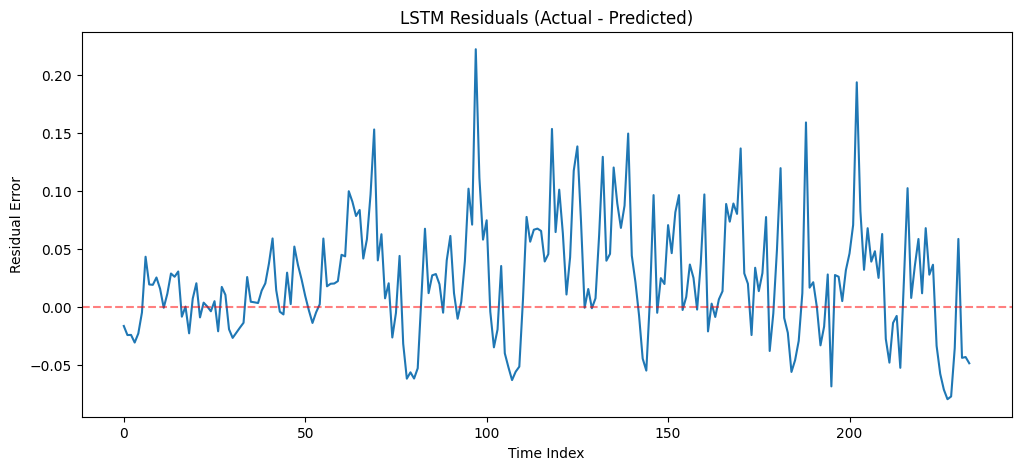

In [53]:
# STEP LSTM-11B: Residual Plot
residuals = y_actual_lstm - y_pred_lstm

plt.figure(figsize=(12, 5))
plt.plot(residuals)
plt.title("LSTM Residuals (Actual - Predicted)")
plt.xlabel("Time Index")
plt.ylabel("Residual Error")
plt.axhline(0, color='r', linestyle='--', alpha=0.5)
plt.show()

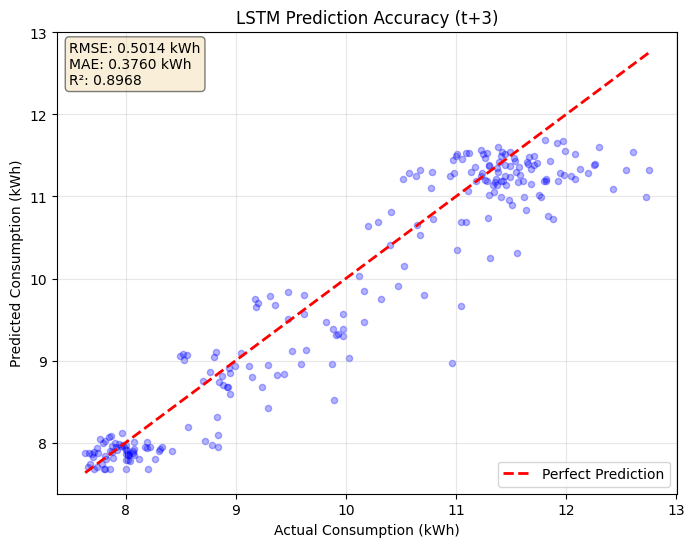

In [54]:
# STEP LSTM-11C: Scatter Plot Predictions vs Actual (Real kWh)
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# Scatter plot of Real vs Real
ax.scatter(y_actual_kwh, y_pred_kwh, alpha=0.3, s=20, color='blue')

# Perfect prediction reference line
min_val = min(y_actual_kwh.min(), y_pred_kwh.min())
max_val = max(y_actual_kwh.max(), y_pred_kwh.max())
ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')

# Metrics box with kWh units
metrics_text = f'RMSE: {rmse_kwh:.4f} kWh\nMAE: {mae_kwh:.4f} kWh\nR²: {r2_val:.4f}'
ax.text(0.02, 0.98, metrics_text, transform=ax.transAxes, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

ax.set_xlabel('Actual Consumption (kWh)')
ax.set_ylabel('Predicted Consumption (kWh)')
ax.set_title(f'LSTM Prediction Accuracy (t+{FORECAST_HORIZON})')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

## LSTM Modeling: Sequential Time-Series Forecasting

### Objective

The Long Short-Term Memory (LSTM) model was developed to forecast the **Average Daily Energy Consumption per Household** for the entire London dataset. Unlike the classification model, this regression model generates a continuous forecast of future demand at **t + 3 days**, serving as a *Grid Planning* tool. It complements the Peak Risk classifier by quantifying expected baseload demand, allowing grid operators to plan for specific capacity requirements.

---

### Data Preparation

The data was aggregated into a single daily time series representing the global average consumption per household.

**Normalization**
- Scaled using `MinMaxScaler` to bound inputs between 0 and 1.

**Sequence Generation**
- Sliding window approach with a **48-day lookback window**.
- Predicts a target **3 days into the future (t + 3)**.

**Splitting**
- Chronological split to preserve temporal order and prevent leakage:
  - First 70 percent: Training set
  - Last 30 percent: Test set

---

### Model Architecture

A stacked LSTM architecture was implemented to capture complex temporal dependencies and seasonality:

- Layer 1: LSTM (75 units, `return_sequences=True`)
- Dropout 1: 0.2 (regularization)
- Layer 2: LSTM (75 units, `return_sequences=True`)
- Dropout 2: 0.2
- Layer 3: LSTM (75 units, `return_sequences=False`)
- Dropout 3: 0.2
- Output Layer: Dense (1 unit) for single-step regression output

---

### Training Process

- Optimizer: Adam (learning rate = 0.001)
- Loss Function: Mean Squared Error (MSE)
- Epochs: 30
- Batch Size: 32
- Validation: Evaluated on the unseen test set (final 30 percent of the timeline)

---

### Model Performance

The model demonstrated strong predictive capability on the test set when evaluated on real-world energy units (kWh):

- RMSE: 0.5014 kWh
- MAE: 0.3760 kWh
- R² Score: 0.8968

An R² score of approximately 0.90 indicates the model captures nearly 90 percent of the variance in electricity consumption, effectively learning weekly and seasonal cycles. The RMSE of approximately 0.50 kWh confirms that, on average, the model's 3-day forecast deviates from actual household consumption by only about half a kilowatt-hour, providing a highly accurate baseline for planning.

---

### Interpretation

The LSTM effectively models the sequential dynamics of energy demand. By looking back 48 days, it identifies seasonal trends (for example, winter heating ramp-up) and weekly cycles (such as weekend usage spikes). The inverse-transformed metrics validate that the model is not just fitting patterns but accurately predicting demand magnitude, functioning as a robust quantitative tool for resource allocation.


In [54]:
# STEP FINAL: Export Predictions for Tableau
# This matches Max's export logic but ensures units are in kWh

# 1. Generate predictions for the Training set too (so we export the full history)
y_train_pred_scaled = model_lstm.predict(X_train_lstm).flatten()

# 2. Inverse Transform everything to real kWh
y_train_actual_kwh = scaler_lstm.inverse_transform(y_train_lstm)
y_train_pred_kwh = scaler_lstm.inverse_transform(y_train_pred_scaled.reshape(-1, 1))

y_test_actual_kwh = scaler_lstm.inverse_transform(y_test_lstm)
y_test_pred_kwh = scaler_lstm.inverse_transform(y_pred_lstm.reshape(-1, 1))

# 3. Align Dates
# The target for X[i] is at index: i + WINDOW_SIZE + FORECAST_HORIZON - 1
target_offset = WINDOW_SIZE + FORECAST_HORIZON - 1

# Get valid dates from the original dataframe
valid_dates = lstm_df['day'].iloc[target_offset:].values

# Ensure lengths match (cutoff any end mismatch if necessary)
total_samples = len(y_train_actual_kwh) + len(y_test_actual_kwh)
export_dates = valid_dates[:total_samples]

# 4. Create DataFrame
export_df = pd.DataFrame({
    'day': export_dates,
    'actual_kwh': np.concatenate([y_train_actual_kwh.flatten(), y_test_actual_kwh.flatten()]),
    'predicted_kwh': np.concatenate([y_train_pred_kwh.flatten(), y_test_pred_kwh.flatten()]),
    'split': ['train'] * len(y_train_actual_kwh) + ['test'] * len(y_test_actual_kwh)
})

# 5. Save
import os
RESULTS_DIR = "build/results"
os.makedirs(RESULTS_DIR, exist_ok=True)
export_path = os.path.join(RESULTS_DIR, 'lstm_tableau_export.csv')
export_df.to_csv(export_path, index=False)

print(f"Exported {len(export_df)} predictions to {export_path}")
print("Preview:")
display(export_df.head())
display(export_df.tail())

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Exported 777 predictions to build/results/lstm_tableau_export.csv
Preview:


,day,actual_kwh,predicted_kwh,split
0,2012-01-12,12.0568,12.0367,train
1,2012-01-13,12.5228,12.0060,train
2,2012-01-14,13.4963,11.9237,train
3,2012-01-15,14.0372,11.8162,train
4,2012-01-16,13.0478,11.7280,train


,day,actual_kwh,predicted_kwh,split
772,2014-02-22,10.7762,10.8600,test
773,2014-02-23,11.4804,10.7431,test
774,2014-02-24,10.4114,10.6171,test
775,2014-02-25,10.2950,10.5080,test
776,2014-02-26,10.2029,10.4593,test
